In [4]:
!pip install pandas

In [7]:
!pip install jieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 28.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'jieba' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'jieba'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314458 sha256=84e664073cd854b0831a747381d4d733e14360a7f81cf2821548dc78deb8ef36
  Stored in directory: /Users/amelia/Library/Caches/pip/wheels/8d/e9/51/2f0a6a9d051293af20e265d3889beae50efe2de72f8511c801
Successfully built jieba


In [ ]:
################# 小甜豆清洗 ###############
import pandas as pd
import jieba
import jieba.posseg as pseg
from collections import Counter
from datetime import datetime

# --- 1. 配置区 ---
INPUT_FILE = 'weibo_xiaotiandou_final.csv'
OUTPUT_FILE = 'weibo_xiaotiandou_cleaned_jieba.csv'

# 筛选日期阈值
TARGET_DATE = datetime(2025, 7, 1)

# 【IP白名单】
POPMART_IPS = [
    '小甜豆', '泡泡玛特', 'Dimoo', 'Molly', 'Labubu', 'Pucky', '毕奇', 
    'Skullpanda', 'Crybaby', 'Hirono', '小野', 'Zsiga', 'Nanci', '若来'
]

# 【黑名单】
EXCLUSION_NAMES = [
    '刘宇', 'INTO1', '尹浩宇', '蔡徐坤', '肖战', '王一博',"宋亚轩","河成云",
    "肖宇梁","张极","杨洋","张九龄","易烊千玺","马嘉祺","李永钦","库里", '宋旻浩',
    '苏新皓','藤谷美紀','晴川','毕雯珺','李现','虞书欣','老妈','叔叔', '田嘉瑞',
    '鞠婧祎','遛娃','冯绍峰','丁程鑫', '梓渝','李昊','檀健次','颜人中','完美身材',
    '张云龙','王承渲','任豪','天生正唯'     
]

# --- 2. 功能函数 ---

def analyze_top_names(df):
    """分析人名频率"""
    print(">>> 正在进行人名频率分析，请稍候...")
    for ip in POPMART_IPS:
        jieba.add_word(ip, tag='nz')

    all_content = "".join(df['帖子内容'].astype(str).tolist())
    words = pseg.cut(all_content)
    
    person_names = []
    for word, flag in words:
        if flag.startswith('nr') and len(word) > 1:
            if word.lower() not in [x.lower() for x in POPMART_IPS]:
                person_names.append(word)

    counts = Counter(person_names)
    print("\n" + "="*40)
    print("【分析结果】数据里出现频率最高的可疑人名：")
    for name, count in counts.most_common(20):
        print(f"{name}: {count} 次")
    print("="*40 + "\n")

def clean_data_with_rules(df):
    """执行清洗（日期 + 明星 + 饭圈词）"""
    original_count = len(df)
    print(f">>> 开始清洗，原始数量: {original_count}")

    # --- 步骤1：日期筛选 (只保留 2025年7月1日及以后) ---
    def is_valid_date(row):
        try:
            # 优先使用"发布日期"列 (假设格式是 11月26日)
            date_str = str(row.get('发布日期', '')).strip()
            year_str = str(row.get('发布年份', '2025')).strip() # 默认2025
            
            if not date_str or date_str == 'nan':
                return False # 没有日期的删掉
            
            # 拼接完整日期字符串 (例如 2025年11月26日)
            if "年" not in date_str:
                full_date_str = f"{year_str}年{date_str}"
            else:
                full_date_str = date_str # 如果自带年份
            
            # 解析
            # 处理 "刚刚", "xx分钟前" -> 默认保留
            if "刚刚" in full_date_str or "前" in full_date_str:
                return True
                
            dt = datetime.strptime(full_date_str, "%Y年%m月%d日")
            return dt >= TARGET_DATE
            
        except:
            # 解析失败的默认删掉
            return False

    # 执行日期筛选
    mask_date = df.apply(is_valid_date, axis=1)
    df = df[mask_date]
    print(f"剔除 {TARGET_DATE.strftime('%Y-%m-%d')} 之前数据后剩余: {len(df)}")

    # --- 步骤2：明星与饭圈词清洗 ---
    pattern = '|'.join(EXCLUSION_NAMES)
    fandom_words = ['舞台', '直拍', '签售', '应援', '打投', '绝美', '营业', '爱豆']
    pattern_fandom = '|'.join(fandom_words)

    # 删除包含黑名单人名的
    mask_name = ~df['帖子内容'].str.contains(pattern, case=False, na=False)
    # 删除包含饭圈用语的
    mask_fandom = ~df['帖子内容'].str.contains(pattern_fandom, case=False, na=False)

    df_clean = df[mask_name & mask_fandom]
    
    # --- 步骤3：去重 ---
    # 建议加上用户名辅助去重，防止不同人发一样的话被误删
    if '用户名' in df_clean.columns:
        df_clean = df_clean.drop_duplicates(subset=['帖子内容', '用户名'])
    else:
        df_clean = df_clean.drop_duplicates(subset=['帖子内容'])
    
    print(f"最终清洗后剩余: {len(df_clean)} (总共删除了 {original_count - len(df_clean)} 条)")
    
    df_clean.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
    print(f"文件已保存至: {OUTPUT_FILE}")

# --- 3. 主程序 ---

if __name__ == '__main__':
    try:
        df = pd.read_csv(INPUT_FILE, encoding='utf-8-sig')
    except:
        df = pd.read_csv(INPUT_FILE, encoding='gbk')
        
    df['帖子内容'] = df['帖子内容'].fillna('')

    # 1. 分析人名 (可选，不需要看分析可以注释掉)
    analyze_top_names(df)
    
    # 2. 执行清洗
    clean_data_with_rules(df)

>>> 正在进行人名频率分析，请稍候...

【分析结果】数据里出现频率最高的可疑人名：
宋亚轩: 170 次
河成云: 97 次
肖宇梁: 43 次
张极: 31 次
杨洋: 27 次
宝宝: 21 次
啊啊啊: 13 次
张九龄: 11 次
易烊千玺: 8 次
宝贝: 7 次
乌龙: 7 次
马嘉祺: 7 次
李永钦: 7 次
高清: 7 次
小可爱: 6 次
美颜: 5 次
莱恩: 5 次
库里: 5 次
汤圆: 5 次
秋叶原: 5 次

>>> 开始清洗，原始数量: 434
剔除 2025-07-01 之前数据后剩余: 86
最终清洗后剩余: 46 (总共删除了 388 条)
文件已保存至: weibo_xiaotiandou_cleaned_jieba.csv


In [ ]:
!pip install pandas matplotlib wordcloud jieba

图片将保存至: /Users/amelia/Desktop/Cityu/周五晚上5507-课件和作业/小组作业/洗完的final数据
正在生成发帖量趋势图...
折线图已保存: /Users/amelia/Desktop/Cityu/周五晚上5507-课件和作业/小组作业/洗完的final数据/小甜豆_发帖量趋势图.png


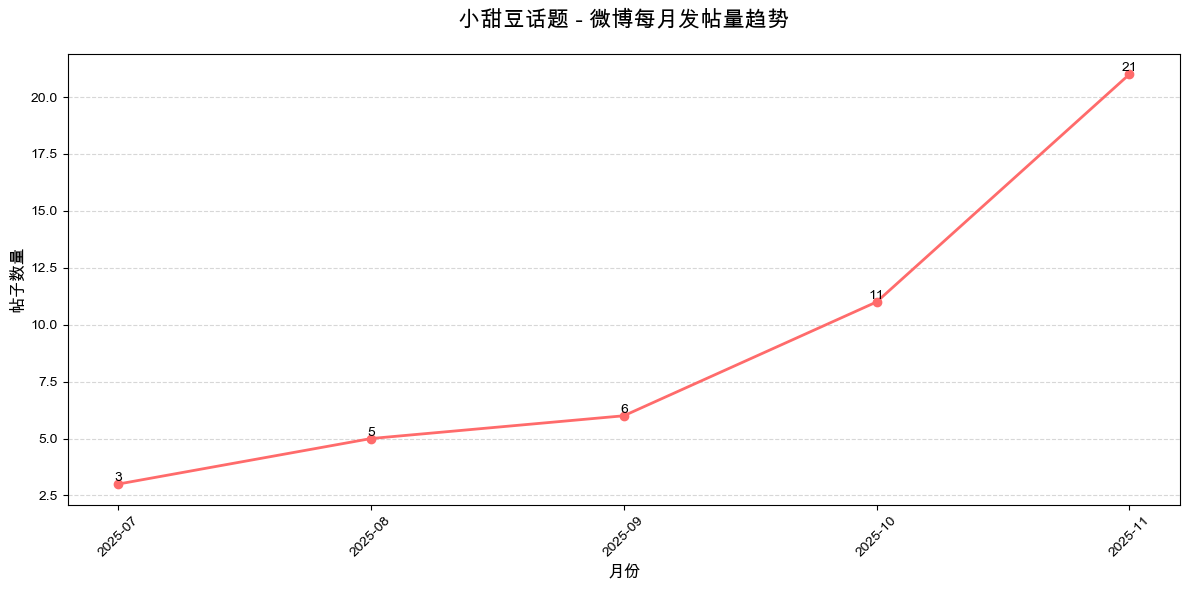

正在生成词云图...
词云图已保存: /Users/amelia/Desktop/Cityu/周五晚上5507-课件和作业/小组作业/洗完的final数据/小甜豆_词云图.png


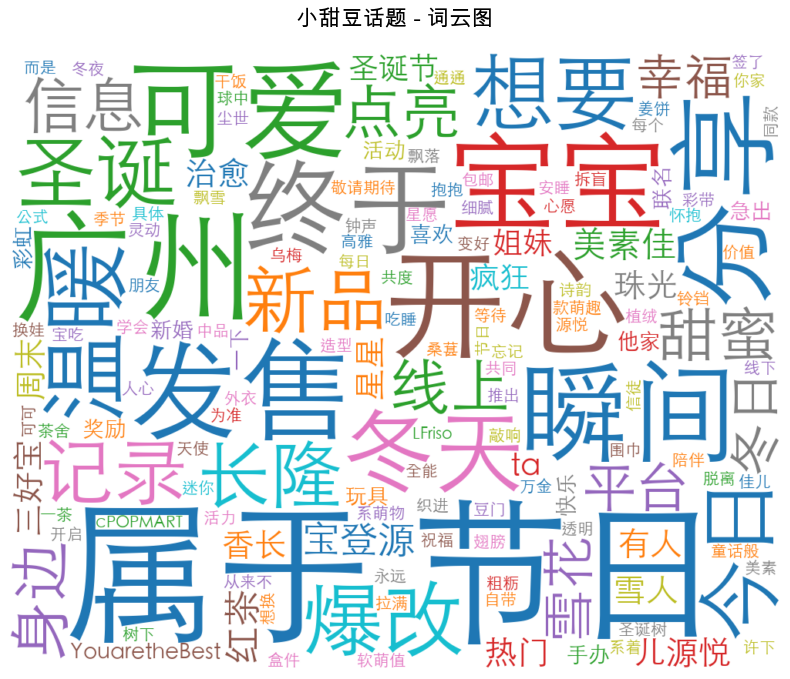

全部完成！


In [ ]:
############## 小甜豆做图 ##############
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import jieba
import re
import os
from datetime import datetime

# --- 1. 配置区 ---
# 你的CSV文件路径
FILE_PATH = '/Users/amelia/Desktop/Cityu/周五晚上5507-课件和作业/小组作业/洗完的final数据/weibo_xiaotiandou_cleaned_jieba.csv'

# 获取文件所在的目录，用于保存图片
SAVE_DIR = os.path.dirname(FILE_PATH)
print(f"图片将保存至: {SAVE_DIR}")

# --- 2. 字体设置 ---
def get_mac_chinese_font():
    """寻找可用字体"""
    font_candidates = [
        '/System/Library/Fonts/STHeiti Light.ttc',
        '/System/Library/Fonts/STHeiti Medium.ttc',
        '/System/Library/Fonts/Hiragino Sans GB.ttc',
        '/Library/Fonts/Arial Unicode.ttf',
        '/System/Library/Fonts/PingFang.ttc',
    ]
    for font in font_candidates:
        if os.path.exists(font): return font
    return None

FONT_PATH_MAC = get_mac_chinese_font()
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False 

# --- 3. 读取数据 ---
try:
    df = pd.read_csv(FILE_PATH, encoding='utf-8-sig')
except:
    df = pd.read_csv(FILE_PATH, encoding='gbk')

df['帖子内容'] = df['帖子内容'].fillna('')
df['发布年份'] = df['发布年份'].astype(str).str.replace('.0', '', regex=False)

# ==============================================================================
# 图表一：发帖量统计折线图
# ==============================================================================
print("正在生成发帖量趋势图...")

def parse_date(row):
    try:
        date_part = str(row['发布日期']).strip()
        if "年" in date_part and "月" in date_part:
            return datetime.strptime(date_part, "%Y年%m月%d日")
        full_date_str = f"{row['发布年份']}年{date_part}"
        return datetime.strptime(full_date_str, "%Y年%m月%d日")
    except:
        return pd.NaT

df['full_date'] = df.apply(parse_date, axis=1)
df_trend = df.dropna(subset=['full_date']).copy()
df_trend['month'] = df_trend['full_date'].dt.to_period('M')
monthly_counts = df_trend['month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index.astype(str), monthly_counts.values, 
         marker='o', linestyle='-', color='#FF6B6B', linewidth=2)

for x, y in zip(monthly_counts.index.astype(str), monthly_counts.values):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('小甜豆话题 - 微博每月发帖量趋势', fontsize=16, pad=20)
plt.xlabel('月份', fontsize=12)
plt.ylabel('帖子数量', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# 保存图片
trend_img_path = os.path.join(SAVE_DIR, '小甜豆_发帖量趋势图.png')
plt.savefig(trend_img_path, dpi=300)
print(f"折线图已保存: {trend_img_path}")
plt.show()

# ==============================================================================
# 图表二：词云图
# ==============================================================================
print("正在生成词云图...")

# 【修改】已把“打卡、可爱”等词从停用词中移除
stopwords = {
    '转发', '微博', '视频', '网页', '链接', '全文', '收起', '展开', 
    '小甜豆', '泡泡玛特', 'POPMART', 'popmart', 
    '一个', '就是', '这个', '真的', '什么', '怎么', '可以', '还有',
    '今天', '现在', '因为', '所以', '但是', '虽然', '日常', 
    '哈哈哈', '哈哈', '超话', '盲盒', '系列', '这套', '这里', 
    '抽到','自己','哪里','时间','场景','这么','有关','开始','前后',
    'Molly', 'molly','出来','labubu','Dimoo','我们','大家','一只','两个',
    '哈哈','啊啊啊','一天','一起',
}

text_content = " ".join(df['帖子内容'].tolist())
text_content = re.sub(r"[^\u4e00-\u9fa5a-zA-Z0-9]", "", text_content)

words = jieba.cut(text_content)
filtered_words = [word for word in words if len(word) > 1 and word not in stopwords]
final_text = " ".join(filtered_words)

if FONT_PATH_MAC:
    wc = WordCloud(
        font_path=FONT_PATH_MAC,  
        background_color='white', 
        width=1000,
        height=800,
        max_words=150,            
        colormap='tab10'          
    ).generate(final_text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('小甜豆话题 - 词云图', fontsize=16, pad=20)
    
    # 保存图片
    wordcloud_img_path = os.path.join(SAVE_DIR, '小甜豆_词云图.png')
    plt.savefig(wordcloud_img_path, dpi=300)
    print(f"词云图已保存: {wordcloud_img_path}")
    
    plt.show()
else:
    print("无法生成词云图：未找到合适的中文字体文件。")

print("全部完成！")

In [ ]:
############## Dimoo清洗 part 1 ################
import pandas as pd
import jieba
import jieba.posseg as pseg
from collections import Counter

# --- 配置区 ---
INPUT_FILE = 'weibo_Dimoo_Future_2025.csv'
OUTPUT_FILE = 'Dimoo_人名提取_Cleaned.csv'

# 1. 【百家姓库】(保持不变，第一道防线)
COMMON_SURNAMES = set(
    "赵钱孙李周吴郑王冯陈褚卫蒋沈韩杨朱秦尤许何吕施张孔曹严华金魏陶姜"
    "戚谢邹喻柏水窦章云苏潘葛奚范彭郎鲁韦昌马苗凤花方俞任袁柳酆鲍史唐"
    "费廉岑薛雷贺倪汤滕殷罗毕郝邬安常乐于时傅皮卞齐康伍余元卜顾孟平黄"
    "和穆萧尹姚邵湛汪祁毛禹狄米贝明臧计伏成戴谈宋茅庞熊纪舒屈项祝董梁"
    "杜阮蓝闵席季麻强贾路娄危江童颜郭梅盛林刁钟徐邱骆高夏蔡田樊胡凌霍"
    "虞万支柯昝管卢莫经房裘缪干解应宗丁宣邓郁单杭洪包诸左石崔吉钮龚程"
    "嵇邢滑裴陆荣翁荀羊於惠甄曲家封芮羿储靳汲邴糜松井段富巫乌焦巴弓牧"
    "隗山谷车侯宓蓬全郗班仰秋仲伊宫宁仇栾暴甘钭厉戎祖武符刘景詹束龙叶"
    "幸司韶郜黎蓟薄印宿白怀蒲邰从鄂索咸籍赖卓蔺屠蒙池乔阴鬱胥能苍双闻"
    "莘党翟谭贡劳逄姬申扶堵冉宰郦雍却璩桑桂濮牛寿通边扈燕冀郏浦尚农温"
    "别庄晏柴瞿阎充慕连茹习宦艾鱼容向古易慎戈廖庾终暨居衡步都耿满弘匡"
    "国文寇广禄阙东欧利师巩聂关荆肖"
)

# 2. 【强力误判排除库】 (这里放你不想看到的非人名)
# 包含了地名、盲盒术语、常用虚词等
IGNORE_WORDS = {
    # 地名/场所 (易误判因为首字是姓)
    '石家庄', '长春', '长沙', '常州', '常熟', '海口', '海南', '上海', '北京', 
    '天津', '西安', '青岛', '成都', '重庆', '苏州', '杭州', '南京', '武汉',
    '迪士尼', '环球', '影城', '乐园', '博物馆', '美术馆', '全家', '便利店',
    '潘家园','连云港','吉隆坡',
    
    # 盲盒/交易术语
    '全家福', '大团圆', '端盒', '散盒', '中盒', '大盒', '小盒', '外盒',
    '好价', '高价', '低价', '原价', '自价', '心理价', '定金', '尾款',
    '确认', '未拆', '拆摆', '无瑕', '官瑕', '大瑕', '小瑕',
    '出娃', '收娃', '换娃', '排娃', '蹲娃', '带娃', '退坑',
    '实物', '现货', '预售', '链接', '备注', '包邮', '到付',
    '隐藏', '热款', '雷款', '基础', '常规', '异色',
    '成色', '状态', '身份', '卡片', '配件', '部分',
    
    # 称呼/关系
    '老师', '老是', '老板', '老伴', '老公', '老婆', '老妈', '老爸',
    '太太', '劳斯', '大大', '姐妹', '富贵', '锦鲤', '欧皇', '非酋',
    '小宝', '小心', '小说', '小可爱', '小甜豆', '小黑', '小白', '小红',
    '宝宝', '宝贝', '贝儿', '花花', '天天', '年年', '家人们', '路人',
    '朋友', '对象', '舍友', '室友', '同事', '同学', '客服', '快递',
    '明星',
    
    # 常用动词/形容词/虚词 (容易被切分为人名)
    '安利', '完美', '正常', '真心', '本来', '平价', '感觉', '感谢',
    '可以', '可能', '可爱', '可惜', '可怕', '看来', '看到',
    '这个', '那个', '这里', '那里', '这些', '那些',
    '一直', '一般', '一样', '一起', '一定', '一共', '一切',
    '不要', '不仅', '不但', '不好', '不行', '不错',
    '如果', '如何', '如今', '只有', '只要', '只是',
    '非常', '特别', '比较', '相当', '真的', '真是',
    '好像', '好多', '好久', '好运', '好玩', '好看',
    '高光', '高兴', '应该', '应用', '因为', '因此',
    '还是', '还有', '还没', '还行', '还愿', '许愿',
    '但是', '大家', '大部分', '大小', '大量',
    '自己', '自然', '自由', '自动', '有些', '有点',
    '最近', '最后', '最好', '最终', '最初',
    '开始', '开心', '开出', '开盒', '开袋',
    '米奇', '米妮', '巴斯', '胡迪', '三眼仔','毛绒','荣耀',
    '温馨','明白','荣耀','童真','周生生','曲奇','汤圆','乐章','罗盘',
    '雷霆','钟声','幸运星','蓝天','万圣节','高清','米白','和蒂蒂','蓝天白云',
    '蓝白','曲奇','和黛丝','舒蝶翼麟',
    
}

def analyze_names_final():
    print(f"正在读取 {INPUT_FILE} ...")
    try:
        df = pd.read_csv(INPUT_FILE, encoding='utf-8-sig')
    except:
        df = pd.read_csv(INPUT_FILE, encoding='gbk')
    
    df['帖子内容'] = df['帖子内容'].fillna('')
    
    # 保护Dimoo专有词
    print(">>> 加载 Dimoo 专有词典...")
    dimoo_ips = ['Dimoo', 'DIMOO', 'Molly', 'Labubu', 'Skullpanda', '泡泡玛特', 'Popmart']
    for ip in dimoo_ips:
        jieba.add_word(ip, tag='nz')

    print(f">>> 正在分析 {len(df)} 条数据，过滤垃圾词汇...")
    
    all_text = "".join(df['帖子内容'].astype(str).tolist())
    words = pseg.cut(all_text)
    
    candidates = []
    for word, flag in words:
        # 1. 词性 nr，长度 2-4
        if flag.startswith('nr') and 2 <= len(word) <= 4:
            
            # 2. 必须百家姓开头
            if word[0] not in COMMON_SURNAMES:
                continue
            
            # 3. 拒绝叠词
            if word[0] == word[1]:
                continue

            # 4. 【重点】不在强力排除库中
            if word in IGNORE_WORDS:
                continue
            
            # 5. 额外规则：过滤掉“小”开头但明显不是人名的 (如 小开心)
            # 很多“小X”被误判，我们只保留看起来像名字的
            # 如果你担心误杀“小鬼”、“小宋”等明星，可以注释掉下面两行
            if word.startswith('小') and word[1:] in IGNORE_WORDS:
                 continue

            candidates.append(word)

    # 统计
    counts = Counter(candidates)
    # 只保留出现超过1次的
    data = [(name, count) for name, count in counts.most_common() if count > 1]
    
    df_result = pd.DataFrame(data, columns=['疑似人名', '出现频次'])
    
    print(f"\n>>> 识别完成！共提取 {len(df_result)} 个疑似人名。")
    df_result.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
    print(f"文件已保存至: {OUTPUT_FILE}")
    print("现在的列表应该非常干净了！请打开Excel筛选明星名字。")

if __name__ == '__main__':
    analyze_names_final()

正在读取 weibo_Dimoo_Future_2025.csv ...
>>> 加载 Dimoo 专有词典...
>>> 正在分析 970 条数据，过滤垃圾词汇...

>>> 识别完成！共提取 18 个疑似人名。
文件已保存至: Dimoo_人名提取_Cleaned.csv
现在的列表应该非常干净了！请打开Excel筛选明星名字。


In [ ]:
############## Dimoo清洗 part 2 ################
import pandas as pd
from datetime import datetime

# --- 配置区 ---
INPUT_FILE = 'weibo_Dimoo_Future_2025.csv'
OUTPUT_FILE = 'weibo_Dimoo_Cleaned_Final.csv'

# 【黑名单】
EXCLUSION_NAMES = [
    '易烊千玺', '王俊凯', '王源', '刘宇', '周深', '颜人中',
    '汪苏','吴磊','宋雨琦','李佳琦','李贵','周深',  '刘耀文',
    '文俊辉', '纪凡','王宁'         
]

# 【筛选阈值】：2025年7月1日
TARGET_DATE = datetime(2025, 7, 1)

def clean_data_advanced():
    print("正在读取数据...")
    try:
        df = pd.read_csv(INPUT_FILE, encoding='utf-8-sig')
    except:
        df = pd.read_csv(INPUT_FILE, encoding='gbk')
    
    # 填充空值
    df['帖子内容'] = df['帖子内容'].fillna('')
    df['用户名'] = df['用户名'].fillna('')
    df['发布日期'] = df['发布日期'].fillna('')
    df['发布时间'] = df['发布时间'].fillna('')

    original_count = len(df)
    print(f"原始数据量: {original_count}")

    # --- 1. 日期筛选 (只留 7月及以后) ---
    print("正在筛选 2025年7月1日 之后的数据...")
    
    def is_after_july(date_str):
        try:
            date_str = date_str.strip()
            # 情况1：格式为 "7月1日" (不带年份)
            if "年" not in date_str and "月" in date_str:
                dt = datetime.strptime(date_str, "%m月%d日")
                # 强制指定为 2025 年进行比较
                dt = dt.replace(year=2025)
            
            # 情况2：格式为 "2025年7月1日" (带年份)
            elif "年" in date_str:
                dt = datetime.strptime(date_str, "%Y年%m月%d日")
            
            # 情况3：其他相对时间 (如 "刚刚", "1分钟前")
            else:
                # 既然是在爬最新数据，相对时间默认符合要求
                return True 

            # 比较：是否在 2025-07-01 之后 (包含当天)
            return dt >= TARGET_DATE
            
        except:
            # 解析不了的日期（格式错误的），默认删掉还是保留？
            # 这里建议设为 False 删掉，保证数据质量
            return False

    # 应用筛选
    mask_date = df['发布日期'].apply(is_after_july)
    df = df[mask_date]
    print(f"时间筛选后剩余: {len(df)}")

    # --- 2. 明星黑名单清洗 ---
    if EXCLUSION_NAMES:
        print(f"正在剔除明星内容...")
        pattern = '|'.join(EXCLUSION_NAMES)
        mask_star = df['帖子内容'].str.contains(pattern, case=False, na=False)
        df = df[~mask_star]
        print(f"剔除明星后剩余: {len(df)}")

    # --- 3. 高级去重 ---
    print("正在进行高级去重 (用户名+内容+日期+时间)...")
    subset_cols = ['用户名', '帖子内容', '发布日期', '发布时间']
    df_clean = df.drop_duplicates(subset=subset_cols, keep='first')

    final_count = len(df_clean)
    print(f"最终剩余: {final_count}")
    print(f"总共清洗掉了: {original_count - final_count} 条数据")
    
    df_clean.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
    print(f"保存成功: {OUTPUT_FILE}")

if __name__ == '__main__':
    clean_data_advanced()

正在读取数据...
原始数据量: 970
正在筛选 2025年7月1日 之后的数据...
时间筛选后剩余: 816
正在剔除明星内容...
剔除明星后剩余: 790
正在进行高级去重 (用户名+内容+日期+时间)...
最终剩余: 790
总共清洗掉了: 180 条数据
保存成功: weibo_Dimoo_Cleaned_Final.csv


/var/folders/s6/sk1g7wj563d1jg1lljxwj85w0000gn/T/ipykernel_57466/2893730285.py:42: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  dt = datetime.strptime(date_str, "%m月%d日")


图片将保存至: /Users/amelia/Desktop/Cityu/周五晚上5507-课件和作业/小组作业/洗完的final数据
正在生成发帖量趋势图...
折线图已保存: /Users/amelia/Desktop/Cityu/周五晚上5507-课件和作业/小组作业/洗完的final数据/Dimoo_发帖量趋势图.png


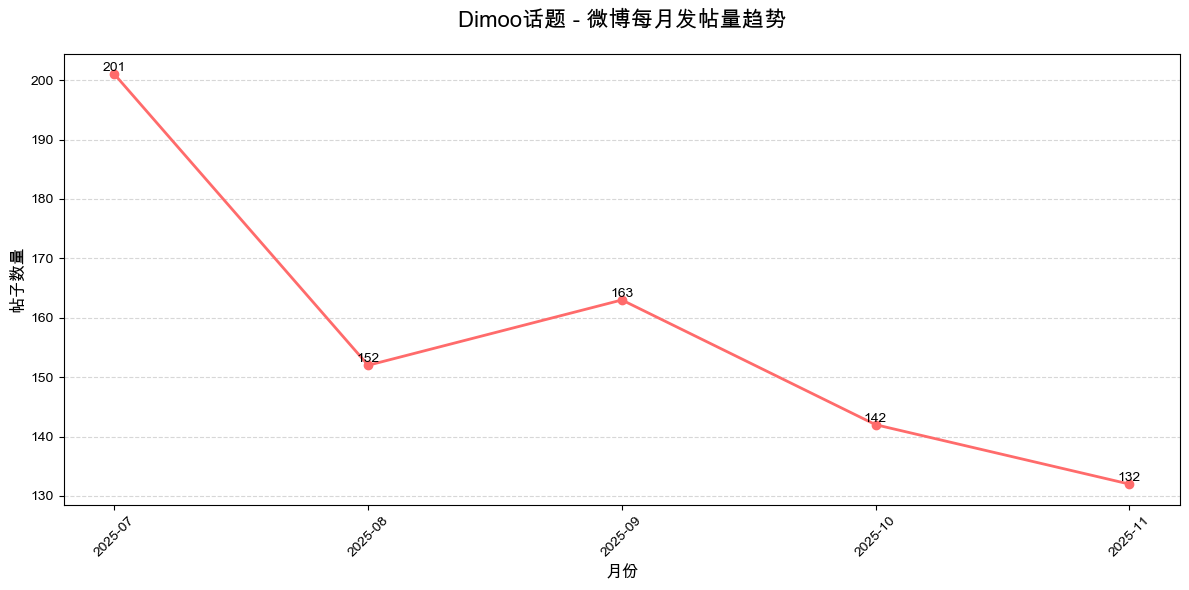

正在生成词云图...
词云图已保存: /Users/amelia/Desktop/Cityu/周五晚上5507-课件和作业/小组作业/洗完的final数据/Dimoo_词云图.png


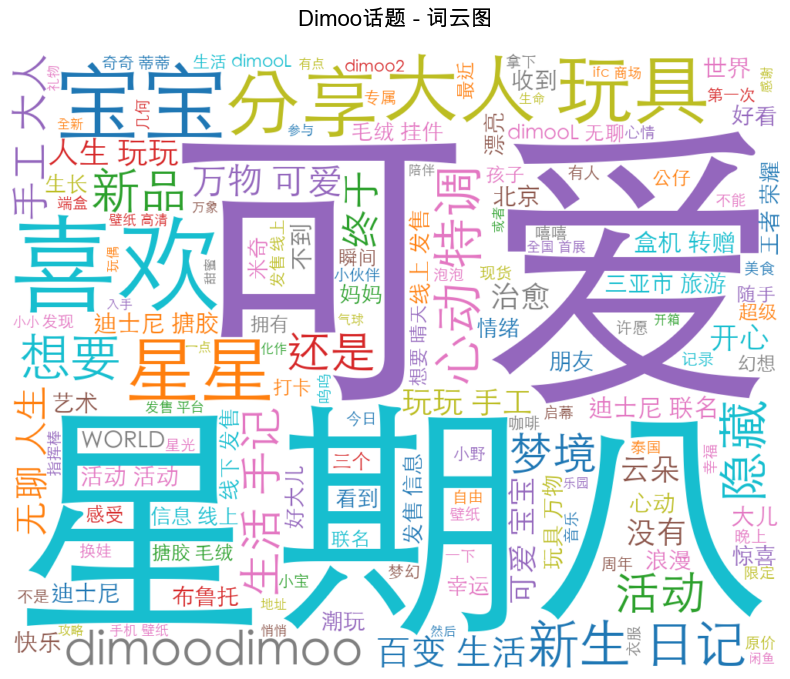

全部完成！


In [20]:
############## Dimoo做图 ##############
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import jieba
import re
import os
from datetime import datetime

# --- 1. 配置区 ---
# 你的CSV文件路径
FILE_PATH = '/Users/amelia/Desktop/Cityu/周五晚上5507-课件和作业/小组作业/洗完的final数据/weibo_Dimoo_Cleaned_Final.csv'

# 获取文件所在的目录，用于保存图片
SAVE_DIR = os.path.dirname(FILE_PATH)
print(f"图片将保存至: {SAVE_DIR}")

# --- 2. 字体设置 ---
def get_mac_chinese_font():
    """寻找可用字体"""
    font_candidates = [
        '/System/Library/Fonts/STHeiti Light.ttc',
        '/System/Library/Fonts/STHeiti Medium.ttc',
        '/System/Library/Fonts/Hiragino Sans GB.ttc',
        '/Library/Fonts/Arial Unicode.ttf',
        '/System/Library/Fonts/PingFang.ttc',
    ]
    for font in font_candidates:
        if os.path.exists(font): return font
    return None

FONT_PATH_MAC = get_mac_chinese_font()
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False 

# --- 3. 读取数据 ---
try:
    df = pd.read_csv(FILE_PATH, encoding='utf-8-sig')
except:
    df = pd.read_csv(FILE_PATH, encoding='gbk')

df['帖子内容'] = df['帖子内容'].fillna('')
df['发布年份'] = df['发布年份'].astype(str).str.replace('.0', '', regex=False)

# ==============================================================================
# 图表一：发帖量统计折线图
# ==============================================================================
print("正在生成发帖量趋势图...")

def parse_date(row):
    try:
        date_part = str(row['发布日期']).strip()
        if "年" in date_part and "月" in date_part:
            return datetime.strptime(date_part, "%Y年%m月%d日")
        full_date_str = f"{row['发布年份']}年{date_part}"
        return datetime.strptime(full_date_str, "%Y年%m月%d日")
    except:
        return pd.NaT

df['full_date'] = df.apply(parse_date, axis=1)
df_trend = df.dropna(subset=['full_date']).copy()
df_trend['month'] = df_trend['full_date'].dt.to_period('M')
monthly_counts = df_trend['month'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index.astype(str), monthly_counts.values, 
         marker='o', linestyle='-', color='#FF6B6B', linewidth=2)

for x, y in zip(monthly_counts.index.astype(str), monthly_counts.values):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Dimoo话题 - 微博每月发帖量趋势', fontsize=16, pad=20)
plt.xlabel('月份', fontsize=12)
plt.ylabel('帖子数量', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# 保存图片
trend_img_path = os.path.join(SAVE_DIR, 'Dimoo_发帖量趋势图.png')
plt.savefig(trend_img_path, dpi=300)
print(f"折线图已保存: {trend_img_path}")
plt.show()

# ==============================================================================
# 图表二：词云图
# ==============================================================================
print("正在生成词云图...")

# 【修改】已把“打卡、可爱”等词从停用词中移除
stopwords = {
    '转发', '微博', '视频', '网页', '链接', '全文', '收起', '展开', 
    '小甜豆', '泡泡玛特', 'POPMART', 'popmart', 
    '一个', '就是', '这个', '真的', '什么', '怎么', '可以', '还有',
    '今天', '现在', '因为', '所以', '但是', '虽然', '日常', 
    '哈哈哈', '哈哈', '超话', '盲盒', '系列', '这套', '这里', 
    '抽到','自己','哪里','时间','场景','这么','有关','开始','前后',
    'Molly', 'molly','出来','labubu','我们','大家','一只','两个',
    '哈哈','啊啊啊','一天','一起','DIMOO','dimoo','三亚','自然','国际','免税',
    'dimooPOPMART','之旅','地点','skullpanda','如果','形状','cdf','拉布','主题',
    '上海','直接','发展局','鹿晗','即将','Dimoo',
}

text_content = " ".join(df['帖子内容'].tolist())
text_content = re.sub(r"[^\u4e00-\u9fa5a-zA-Z0-9]", "", text_content)

words = jieba.cut(text_content)
filtered_words = [word for word in words if len(word) > 1 and word not in stopwords]
final_text = " ".join(filtered_words)

if FONT_PATH_MAC:
    wc = WordCloud(
        font_path=FONT_PATH_MAC,  
        background_color='white', 
        width=1000,
        height=800,
        max_words=150,            
        colormap='tab10'          
    ).generate(final_text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('Dimoo话题 - 词云图', fontsize=16, pad=20)
    
    # 保存图片
    wordcloud_img_path = os.path.join(SAVE_DIR, 'Dimoo_词云图.png')
    plt.savefig(wordcloud_img_path, dpi=300)
    print(f"词云图已保存: {wordcloud_img_path}")
    
    plt.show()
else:
    print("无法生成词云图：未找到合适的中文字体文件。")

print("全部完成！")